<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/Generate_normal_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Stable diffusionのファインチューニングでnormalの画像を作成したときの精度評価**

https://www.notion.so/Stable-diffusion-Lora-bc9427134dcd4596badd624720cc365d

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**尤度で評価**

CorneAIに画像入り(100枚)のフォルダを投入し、各クラスの尤度を計算する。今回は正常画像のトレーニングなので、正常と判定される尤度をピックアップし、平均+-標準偏差を算出する

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data_dir = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal"
csv_files = glob.glob(f"{data_dir}/*")
print(csv_files)


['/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/150.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/150_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/300.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/300_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/600.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/600_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/1200.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/1200_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/2400.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/2400_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal/4800_negative.csv', '/con

In [ ]:
import os
import pandas as pd

# Empty list to store dataframes
dfs = []

# Read each csv file, add 'step' and 'negative_prompt' columns based on file name, and append to the list
for file in csv_files:
    df = pd.read_csv(file, encoding='cp932')

    # Get the step number and negative prompt flag from the file name
    filename = os.path.splitext(os.path.basename(file))[0]

    if "negative" in filename:
        step = int(filename.split("_")[0])
        negative_prompt = True
    else:
        step = int(filename.split("_")[0])
        negative_prompt = False


    # Add 'step' and 'negative_prompt' columns
    df['step'] = step
    df['negative_prompt'] = negative_prompt

    dfs.append(df)

# Concatenate all dataframes
df_combined = pd.concat(dfs, ignore_index=True)

# Calculate mean and standard deviation of '正常' score for each combination of 'step' and 'negative_prompt'
stats_df = df_combined.groupby(['step', 'negative_prompt'])['正常'].agg(['mean', 'std']).reset_index()

stats_df


,step,negative_prompt,mean,std
0,150,False,0.190980,0.314076
1,150,True,0.245239,0.325649
2,300,False,0.566400,0.388795
3,300,True,0.485135,0.355903
4,600,False,0.736174,0.299698
5,600,True,0.815466,0.255144
6,1200,False,0.786072,0.298104
7,1200,True,0.956312,0.034144
8,2400,False,0.928504,0.153809
9,2400,True,0.952455,0.049555


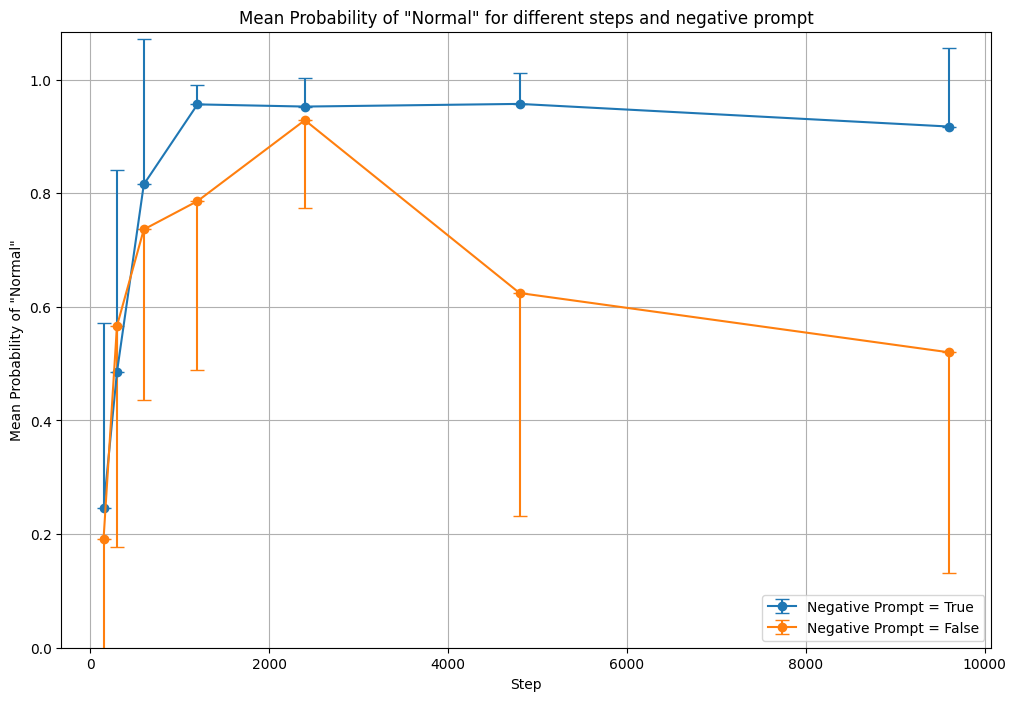

In [ ]:
import matplotlib.pyplot as plt

# Separate dataframes for negative_prompt == True and False
df_true = stats_df[stats_df['negative_prompt'] == True]
df_false = stats_df[stats_df['negative_prompt'] == False]

# Set y limit
ylim_max = max((df_true['mean'] + df_true['std']).max(), (df_false['mean'] + df_false['std']).max())

# Plotting with corrected error bars
plt.figure(figsize=(12, 8))

plt.errorbar(df_true['step'], df_true['mean'], yerr=[[0]*len(df_true['std']), df_true['std']],
             fmt='-o', capsize=5, label='Negative Prompt = True')
plt.errorbar(df_false['step'], df_false['mean'], yerr=[df_false['std'], [0]*len(df_false['std'])],
             fmt='-o', capsize=5, label='Negative Prompt = False')

plt.xlabel('Step')
plt.ylabel('Mean Probability of "Normal"')
plt.ylim(0, ylim_max)
plt.legend()
plt.grid(True)
plt.title('Mean Probability of "Normal" for different steps and negative prompt')
plt.show()



###**Negative promptの有無による比較**

Negative promptの有無による尤度を対応のないt検定で比較する

In [ ]:
# Load the csv files into a dictionary of dataframes
dataframes = {}
for csv_file in csv_files:
    dataframes[csv_file] = pd.read_csv(csv_file, encoding='cp932')
    print(csv_file)

In [ ]:
from scipy.stats import ttest_ind

# Prepare a dictionary to store the results
t_test_results = {}

# Loop over each unique step number
#step_numbers = [150, 300, 600, 1200, 2400, 4800, 9600]
step_numbers = set([int(os.path.splitext(os.path.basename(name))[0]) for name in csv_files if os.path.splitext(os.path.basename(name))[0].isdigit()])
step_numbers = sorted(step_numbers)

for step in step_numbers:
    # Find corresponding dataframe names
    df_name1 = f'{os.path.dirname(csv_file)}/{step}.csv'
    df_name2 = f'{os.path.dirname(csv_file)}/{step}_negative.csv'

    # If both dataframes exist, perform the t-test
    if df_name1 in dataframes and df_name2 in dataframes:
        df1 = dataframes[df_name1]
        df2 = dataframes[df_name2]

        # Perform the t-test on the "正常" column
        t_stat, p_val = ttest_ind(df1["正常"], df2["正常"])
        t_test_results[step] = (t_stat, p_val)

t_test_results #


{150: (-1.1992844627711885, 0.2318505687055421),
 300: (1.5417585192603196, 0.12472895886966971),
 600: (-2.014545842196685, 0.04530505678305323),
 1200: (-5.673639369130452, 4.909468212339316e-08),
 2400: (-1.4821292145929992, 0.13989569503204718),
 4800: (-8.384587714277616, 9.422575922523636e-15),
 9600: (-9.64968078149517, 2.6505735145470533e-18)}

#**FID scoreを用いた画質の評価**

FID for Pytorch
https://github.com/mseitzer/pytorch-fid

FID scoreとは？？
https://data-analytics.fun/2021/12/31/understanding-fid/

In [3]:
!pip install pytorch_fid


In [ ]:
!unzip "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/generated_normal.zip" -d "/content/generated_normal"

In [5]:
import os

# Path to the folder with the real images
true_images_folder = '/content/generated_normal/true'

# Path to the parent folder of the generated images
parent_folder = '/content/generated_normal'

# Get a list of all folders in the parent folder
folders = os.listdir(parent_folder)

# For each folder
for folder in folders:
    # Skip the folder with the real images
    if folder == 'true':
        continue

    # Path to the current folder with generated images
    generated_images_folder = os.path.join(parent_folder, folder)

    # Calculate the FID between the real images and the generated images in the current folder
    !python -m pytorch_fid {true_images_folder} {generated_images_folder}


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 64.4MB/s]
 57% 4/7 [00:08<00:06,  2.17s/it]
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/fid_score.py", line 313, in main
    fid_value = calculate_fid_given_paths(args.path,
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/fid_score.py", line 259, in calculate_fid_given_paths
    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
  File "/usr/local/lib/python

In [6]:
from PIL import Image
import os

def check_image_sizes(folder_path):
    sizes = {}
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):
                img = Image.open(os.path.join(root, file))
                width, height = img.size
                if (width, height) not in sizes:
                    sizes[(width, height)] = 0
                sizes[(width, height)] += 1
    return sizes

# Check sizes of images in the 'true' folder
true_folder = '/content/generated_normal/true'
true_sizes = check_image_sizes(true_folder)
print("Sizes of images in the 'true' folder:", true_sizes)

# Check sizes of images in other folders
parent_folder = '/content/generated_normal'
folders = os.listdir(parent_folder)
for folder in folders:
    if folder == 'true':
        continue
    other_folder = os.path.join(parent_folder, folder)
    other_sizes = check_image_sizes(other_folder)
    print(f"Sizes of images in the '{folder}' folder:", other_sizes)


Sizes of images in the 'true' folder: {(768, 510): 39, (768, 576): 265, (768, 577): 25, (768, 575): 7, (768, 431): 2, (768, 432): 3, (768, 574): 1}
Sizes of images in the 'step600_negative' folder: {(768, 512): 100}
Sizes of images in the 'step1200' folder: {(768, 512): 100}
Sizes of images in the 'step9600' folder: {(512, 512): 100}
Sizes of images in the 'step300' folder: {(768, 512): 100}
Sizes of images in the 'step4800_negative' folder: {(768, 512): 100}
Sizes of images in the 'step600' folder: {(768, 512): 100}
Sizes of images in the 'step150' folder: {(768, 512): 100}
Sizes of images in the 'step300_negative' folder: {(768, 512): 100}
Sizes of images in the 'Step1200_negative' folder: {(768, 512): 100}
Sizes of images in the 'step9600_negative' folder: {(512, 512): 100}
Sizes of images in the 'step2400' folder: {(768, 512): 100}
Sizes of images in the 'step150_negative' folder: {(768, 512): 100}
Sizes of images in the 'step4800' folder: {(768, 512): 100}
Sizes of images in the '